In [1]:
import os
import pandas as pd

# allocate and load the data into a list of csv-files
def load_csv_files(path):
    list_of_csv = []
    for dir in os.listdir(path):
        df = pd.read_csv(path + "/" + dir)
        list_of_csv.append(df)
    
    return list_of_csv


In [2]:
df_list_dash = load_csv_files("Printer3D/Dash/")
df_list_no_dash = load_csv_files("Printer3D/noDash/")

# only use the feature "BUS"
def extract_series(df: pd.DataFrame):
    df = df.dropna()
    df_series = df["BUS"]
    return df_series

# create df with extracted feature column and combine all csv files in relation to class label 
df_dash = pd.DataFrame(list(zip(extract_series(df_list_dash[0]), extract_series(df_list_dash[1]), extract_series(df_list_dash[2]))), columns=["Dash0", "Dash1", "Dash2"])
df_no_dash = pd.DataFrame(list(zip(extract_series(df_list_no_dash[0]), extract_series(df_list_no_dash[1]), extract_series(df_list_no_dash[2]))), columns=["No_Dash0", "No_Dash1", "No_Dash2"])

# merge class related dfs together
df_merged = pd.concat([df_no_dash, df_dash])

In [3]:
# function for mergin the class related dfs - alternative method 
def automated_series_merging(list_dfs: list):
    series_list = []
    for df in list_dfs:
        series_list.append(extract_series(df))

    df = pd.DataFrame(series_list)
    df = df.T
    for i in range(0, (len(df.columns))):
        df.columns.values[i] = ("Dash" + str(i))
    return df

auto_df = automated_series_merging(df_list_dash)
# auto_df = auto_df.dropna()


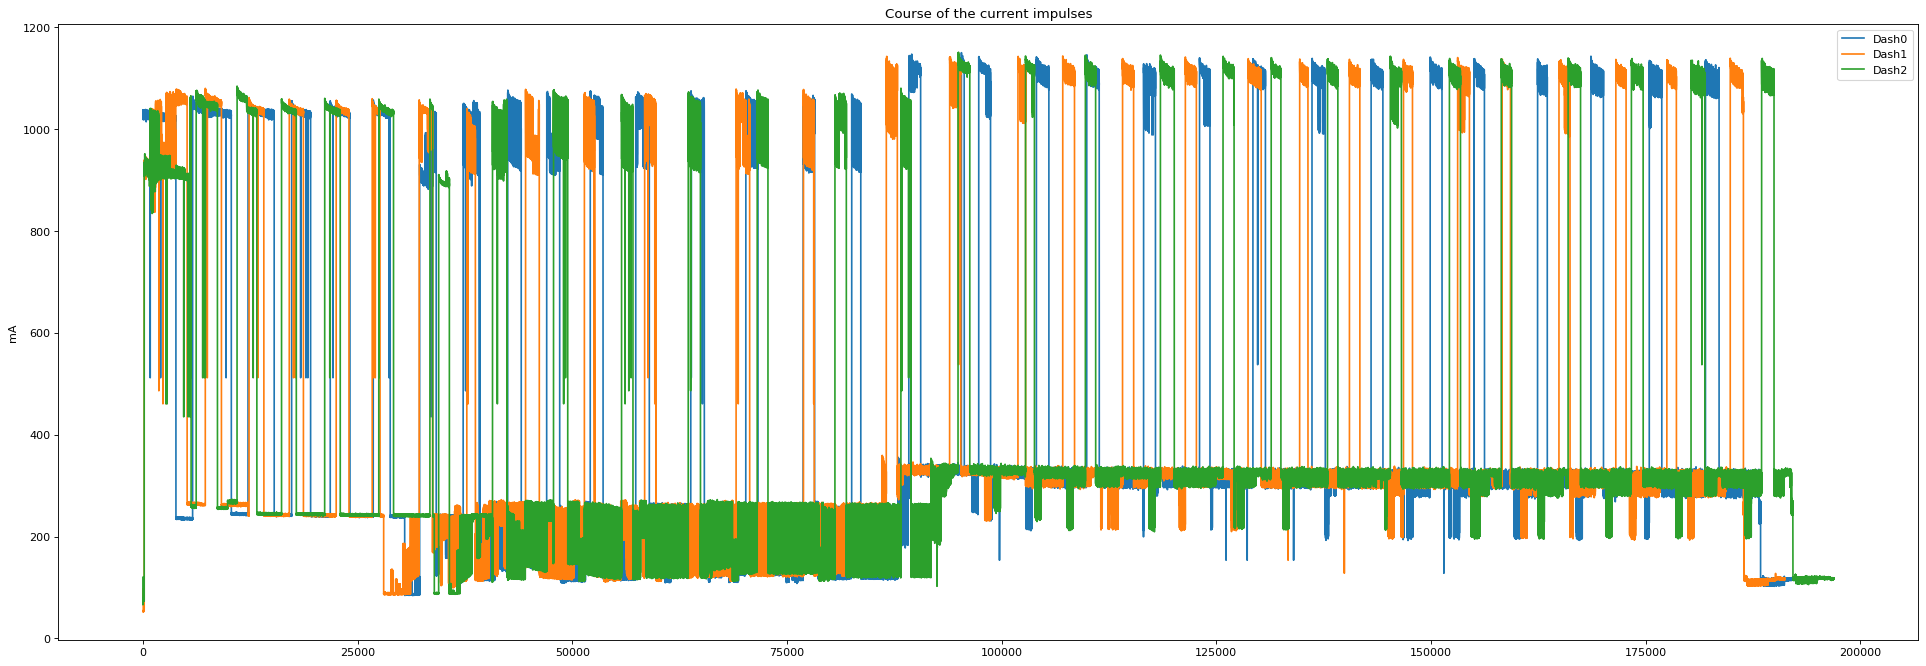

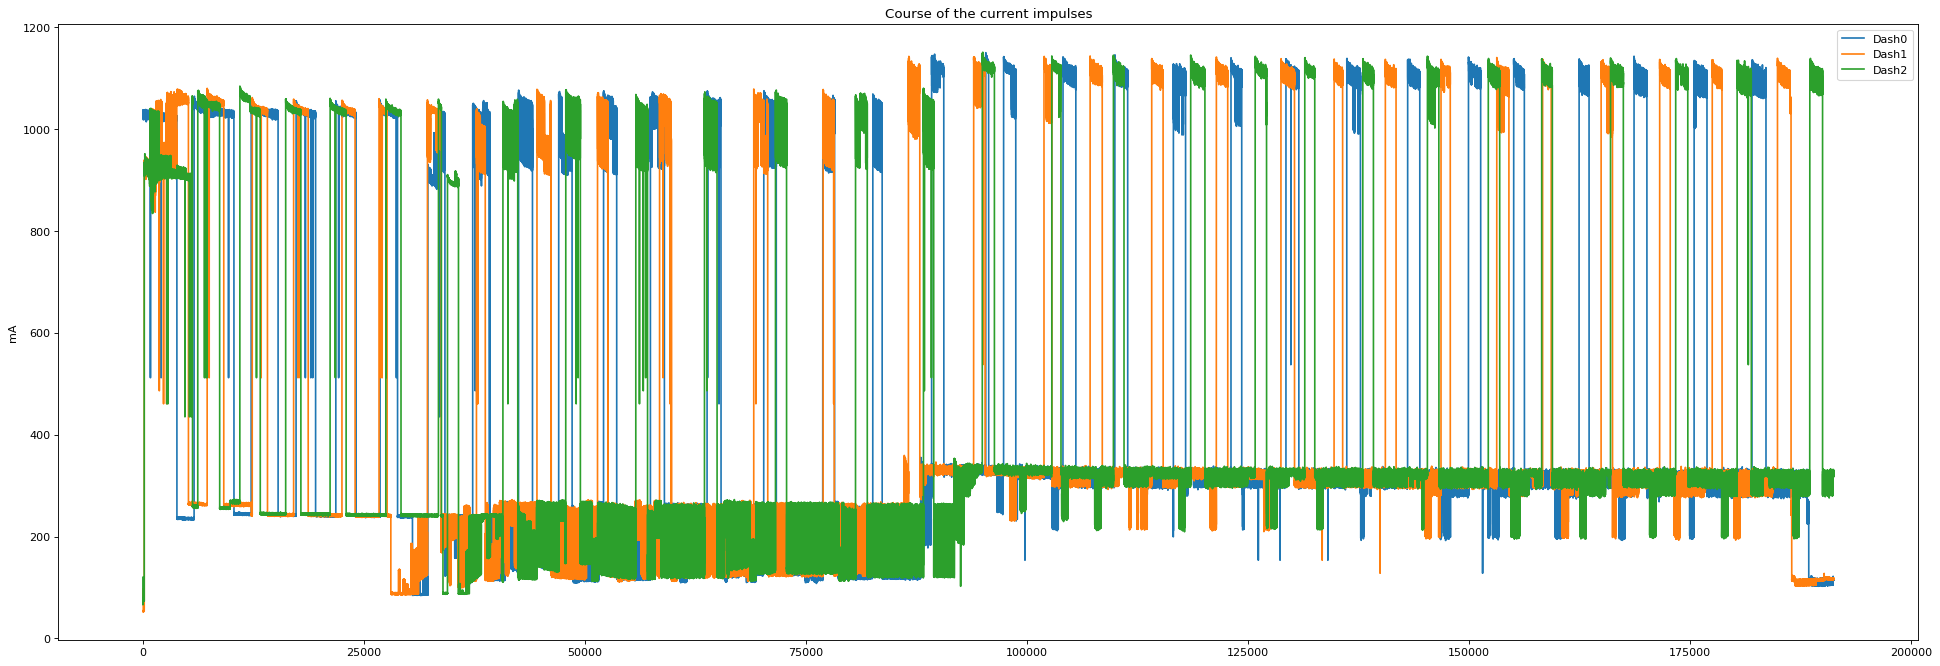

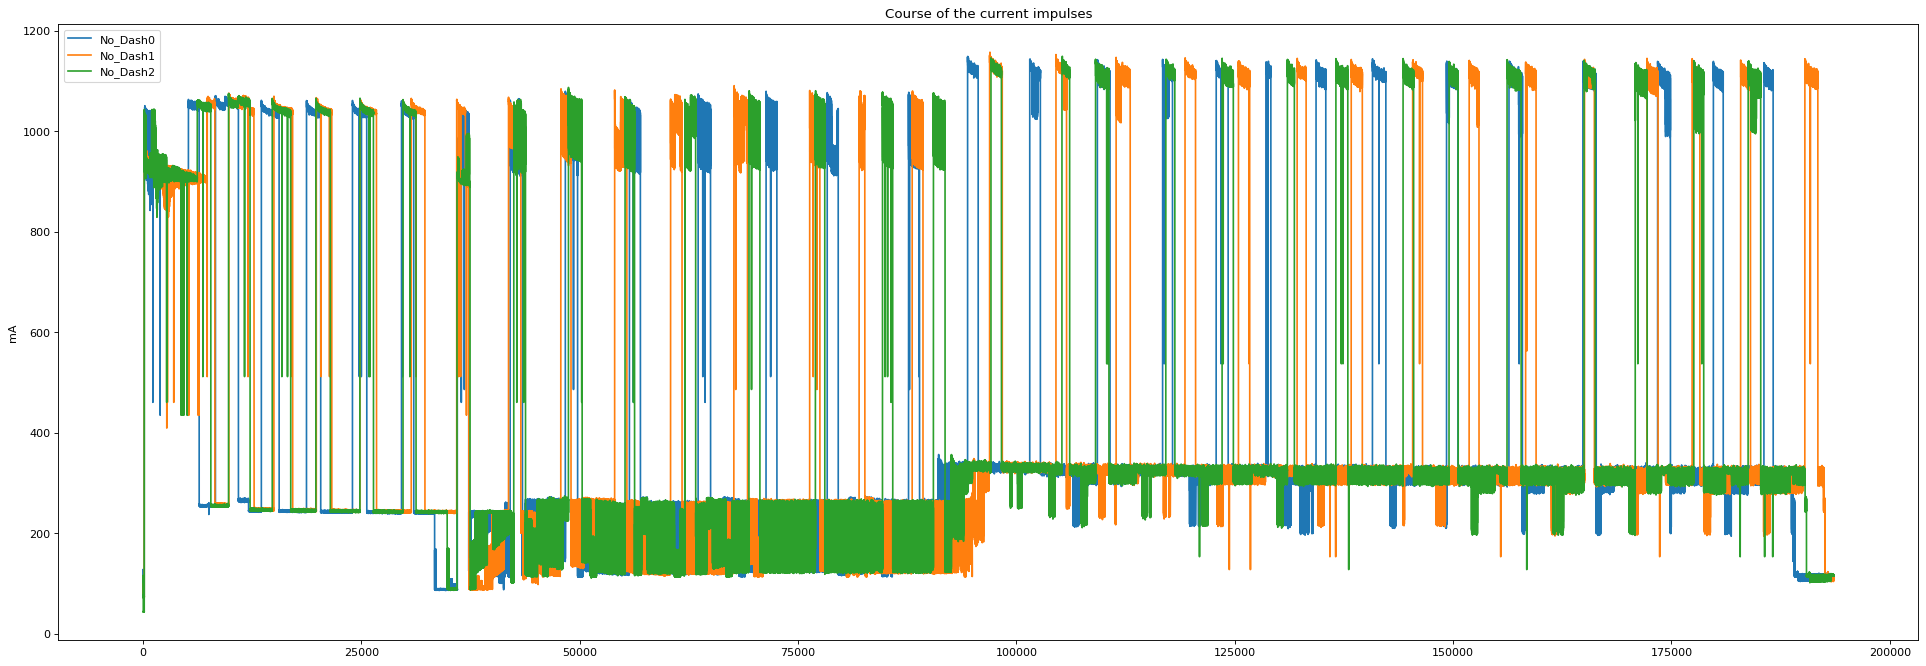

c:\Users\sandr\source\repos\Printer_3D_Predictive_Maintainence\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


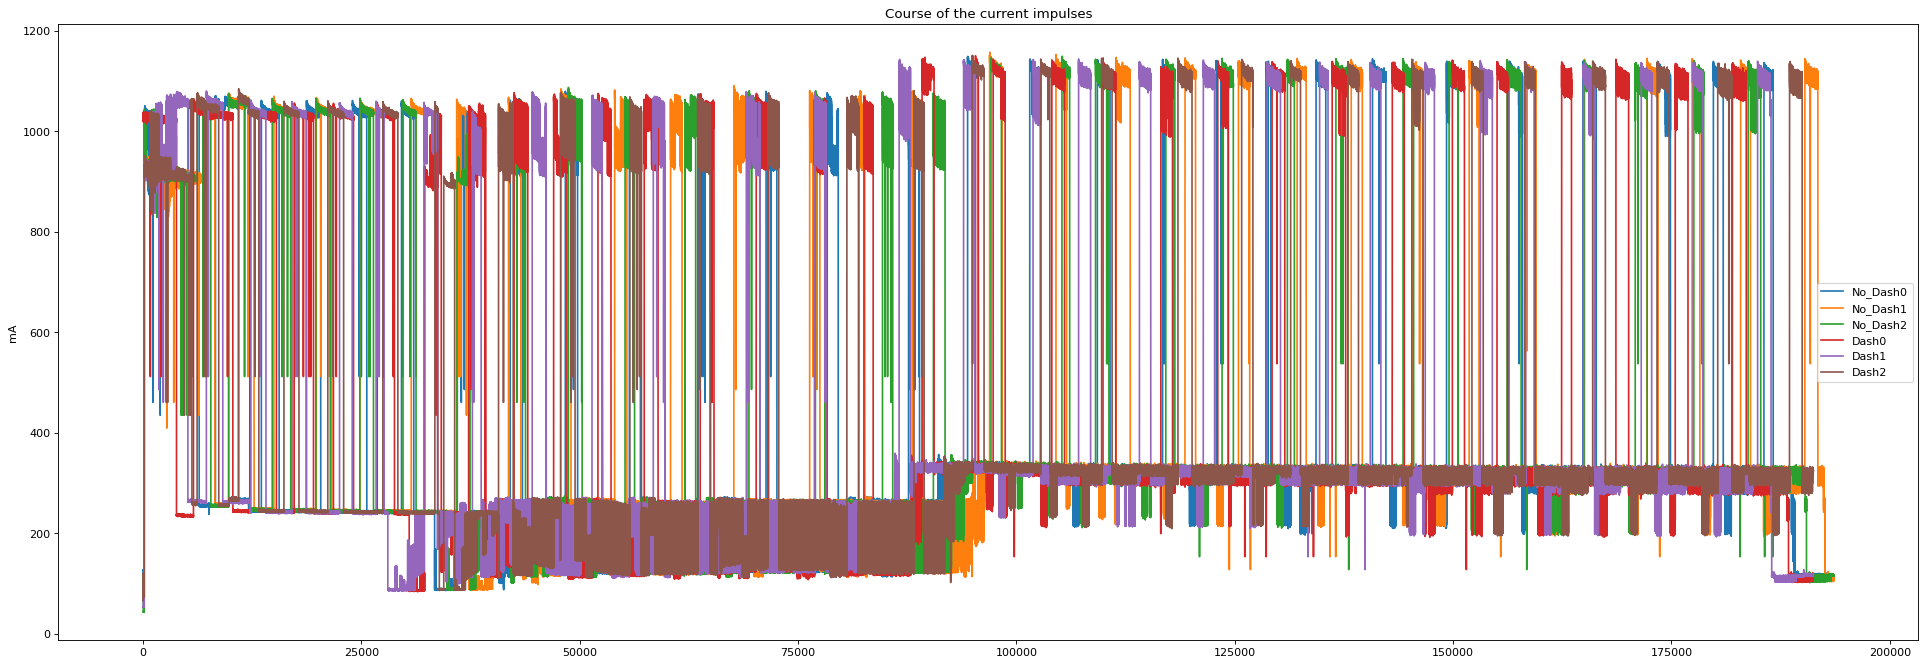

In [4]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# function for plotting the current pulses
def create_current_pulses_plot(df: pd.DataFrame):
    length = len(df.columns)
    figure(figsize=(30, 10), dpi=80)
    # plot lines
    for column in df.columns:
        plt.plot(df[column], label = column, linestyle="-")

    plt.title("Course of the current impulses")
    plt.legend()
    plt.ylabel("mA")
    plt.show()

# visualize single class dfs (also: alternative method)  and merged dfs
create_current_pulses_plot(auto_df)
create_current_pulses_plot(df_dash)
create_current_pulses_plot(df_no_dash)
create_current_pulses_plot(df_merged)



# Preprocessing part for training the Neural Network

In [4]:
import os 
import pandas as pd 
import numpy as np

# load the data again and create lists in relation to the classes
def load_datasets(path):
    dash_list = []
    nodash_list = []
    for dirs in os.listdir(path=path):

        # determine to which class the Determine to which class the file belongs
        if "no" in dirs:
            for dir in os.listdir(os.path.join(path,dirs)):
                df = pd.read_csv(os.path.join(path,dirs, dir))

                # only use "BUS" feature column
                df.dropna(inplace=True)
                df = df[["BUS"]]
                nodash_list.append(df)

        else:
            for dir in os.listdir(os.path.join(path,dirs)):
                df = pd.read_csv(os.path.join(path,dirs, dir))

                 # only use "BUS" feature column
                df = df[["BUS"]]
                df.dropna(inplace=True)
                dash_list.append(df)

    return nodash_list, dash_list

In [6]:
def preprocess_timeseries_data(nodash_list, dash_list, series_size, shift):

    # processing of noDash data
    noDash= []
    noDash_df = pd.concat([nodash_list[0], nodash_list[1]])
    noDash_df.reset_index(inplace=True)
    noDash_series = noDash_df["BUS"]
    size_noDash_series = noDash_series.size

    # loop over df series with window size and shift 
    for i in range(0,(size_noDash_series-(series_size-1)),shift):
        noDash.append(noDash_series.loc[i:(i+series_size-1)].to_numpy())
    
    # processing of Dash data
    Dash = []
    Dash_df = pd.concat([dash_list[0], dash_list[1]])
    Dash_df.reset_index(inplace=True)
    Dash_series = Dash_df["BUS"]
    size_Dash_series = Dash_series.size

     # loop over df series with window size and shift 
    for i in range(0,(size_Dash_series-(series_size-1)),shift):
        Dash.append(Dash_series.loc[i:(i+series_size-1)].to_numpy())
    
    return noDash, Dash

In [22]:
from sklearn.preprocessing import MinMaxScaler
def prepare_for_training(noDash, Dash):

    # load data as numpy array
    noDash_np = np.array(noDash)
    Dash_np = np.array(Dash)

    # create numeric labels
    Dash_labels = np.ones(Dash_np.shape[0], )
    noDash_labels = np.zeros(noDash_np.shape[0], )

    train_data = np.concatenate((noDash_np,Dash_np))
    train_labels = np.concatenate((noDash_labels,Dash_labels))
    
    # normalize the data
    minmaxscale = MinMaxScaler()
    train_data = minmaxscale.fit_transform(train_data)
    np.random.seed(69)
    np.random.shuffle(train_data)
    np.random.seed(69)
    np.random.shuffle(train_labels)
    return train_data, train_labels

In [23]:
nodash_list, dash_list = load_datasets("Printer3D")

# use shift=8 and series_size=5000 (window size)
noDash, Dash = preprocess_timeseries_data(nodash_list, dash_list,5000,8)
del nodash_list, dash_list
train_data, train_labels = prepare_for_training(noDash, Dash)
del noDash, Dash
print(train_labels.shape)
print(train_data.shape)

(100617,)
(100617, 5000)


In [13]:
input_data = train_data.reshape(train_data.shape[0], train_data.shape[1],1)
del train_data
input_data.shape

(100617, 5000, 1)

# Training and validating the Neural Network

In [14]:
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras.losses import SparseCategoricalCrossentropy
                                                  
model = Sequential(
    [
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5000,1)),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=4),
        
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=4),
        Conv1D(filters=32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation = "relu", name = "hidden4"),
        Dense(50, activation = "relu", name = "hidden6"),
        Dense(2, activation ="softmax", name = "Output"),
    ]
)
model.compile(optimizer = "adam", loss=SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])
model.summary()
model.fit(input_data, train_labels, epochs = 5, validation_split = 0.1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 4998, 32)          128       
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 1249, 32)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1247, 32)          3104      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 311, 32)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 309, 32)           3104      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 77, 32)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 75, 32)           